In [ ]:
import os  #  for loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img

# Required modules for model
import torch.nn as nn
import statistics
import torchvision.models as models

from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


In [ ]:
from google.colab import drive, files


In [ ]:
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:08<00:00, 201MB/s]
100% 1.04G/1.04G [00:08<00:00, 129MB/s]


In [ ]:
! mkdir flickr
! unzip flickr8k.zip -d flickr

mkdir: cannot create directory ‘flickr’: File exists
Archive:  flickr8k.zip
replace flickr/Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Model Utilities

In [ ]:
spacy_eng = spacy.load("en_core_web_sm")

In [ ]:
# Vocabulary class (for mapping words to indices and vice versa)
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(str(text))]

    # Build vocabulary from a list of sentences
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        print(tokenized_text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [ ]:

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


# Locate dataset and model address

In [ ]:
root_folder = "flickr/Images/"
annotation_file = "flickr/captions.txt"

file_address = "/content/drive/MyDrive/model_checkpointsnew.pth.tar"

# Loading and saving model

In [ ]:
def save_checkpoint(state, filename=file_address):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

# Building the main model

### photos --> CNN --> RNN --> Result

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN

        # The InceptionV3 models is already pretrained with ImageNet (Using transfer Learning)
        self.inception = models.inception_v3(pretrained=True)

        # Replace Fully connected layer with a linear layer, with features of original fc with size of embed_size
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        if logits_flag:
            features = self.inception(images).logits
        else:
            features = self.inception(images)

        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()

        # map text to a dimensional space for representation
        self.embed = nn.Embedding(vocab_size, embed_size)

        # using LSTM to
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [ ]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = True
save_model = False
train_CNN = False
logits_flag = True

transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, dataset = get_loader(
    root_folder = root_folder,
    annotation_file = annotation_file,
    transform=transform,
    num_workers=2,
)


# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 100

# for tensorboard
writer = SummaryWriter("runs/flickr")
step = 0


In [ ]:
# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

if load_model:
    step = load_checkpoint(torch.load(file_address), model, optimizer)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 159MB/s] 


=> Loading checkpoint


In [ ]:
for epoch in range(num_epochs):
    logits_flag = True
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)
        outputs = model(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        writer.add_scalar("Training loss", loss.item(), global_step=step)
        step += 1

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()

Epoch [1/100]
=> Saving checkpoint


Epoch [2/100]
=> Saving checkpoint


Epoch [3/100]
=> Saving checkpoint


Epoch [4/100]
=> Saving checkpoint


Epoch [5/100]
=> Saving checkpoint


Epoch [6/100]
=> Saving checkpoint


Epoch [8/100]
=> Saving checkpoint


Epoch [9/100]
=> Saving checkpoint


Epoch [10/100]
=> Saving checkpoint


Epoch [11/100]
=> Saving checkpoint


Epoch [12/100]
=> Saving checkpoint


Epoch [13/100]
=> Saving checkpoint


Epoch [14/100]
=> Saving checkpoint


Epoch [15/100]
=> Saving checkpoint


Epoch [16/100]
=> Saving checkpoint


Epoch [17/100]
=> Saving checkpoint


Epoch [18/100]
=> Saving checkpoint


Epoch [19/100]
=> Saving checkpoint


Epoch [20/100]
=> Saving checkpoint


Epoch [21/100]
=> Saving checkpoint


Epoch [22/100]
=> Saving checkpoint


Epoch [23/100]
=> Saving checkpoint


Epoch [24/100]
=> Saving checkpoint


Epoch [25/100]
=> Saving checkpoint


Epoch [26/100]
=> Saving checkpoint


Epoch [27/100]
=> Saving checkpoint


Epoch [28/100]
=> Saving checkpoint


Epoch [29/100]
=> Saving checkpoint


Epoch [30/100]
=> Saving checkpoint


Epoch [31/100]
=> Saving checkpoint


Epoch [32/100]
=> Saving checkpoint


Epoch [33/100]
=> Saving checkpoint


Epoch [34/100]
=> Saving checkpoint


Epoch [35/100]
=> Saving checkpoint


Epoch [36/100]
=> Saving checkpoint


Epoch [37/100]
=> Saving checkpoint


Epoch [38/100]
=> Saving checkpoint


Epoch [39/100]
=> Saving checkpoint


Epoch [40/100]
=> Saving checkpoint


Epoch [41/100]
=> Saving checkpoint


Epoch [42/100]
=> Saving checkpoint


Epoch [43/100]
=> Saving checkpoint


Epoch [44/100]
=> Saving checkpoint


Epoch [45/100]
=> Saving checkpoint


Epoch [46/100]
=> Saving checkpoint


Epoch [47/100]
=> Saving checkpoint


Epoch [48/100]
=> Saving checkpoint


Epoch [49/100]
=> Saving checkpoint


Epoch [50/100]
=> Saving checkpoint


Epoch [51/100]
=> Saving checkpoint


Epoch [52/100]
=> Saving checkpoint


Epoch [53/100]
=> Saving checkpoint


Epoch [54/100]
=> Saving checkpoint


Epoch [55/100]
=> Saving checkpoint


Epoch [56/100]
=> Saving checkpoint


Epoch [57/100]
=> Saving checkpoint


Epoch [58/100]
=> Saving checkpoint


Epoch [59/100]
=> Saving checkpoint


Epoch [60/100]
=> Saving checkpoint


Epoch [61/100]
=> Saving checkpoint


Epoch [62/100]
=> Saving checkpoint


Epoch [63/100]
=> Saving checkpoint


Epoch [64/100]
=> Saving checkpoint


Epoch [65/100]
=> Saving checkpoint


Epoch [66/100]
=> Saving checkpoint


Epoch [67/100]
=> Saving checkpoint


Epoch [68/100]
=> Saving checkpoint


Epoch [69/100]
=> Saving checkpoint


Epoch [70/100]
=> Saving checkpoint


Epoch [71/100]
=> Saving checkpoint


Epoch [72/100]
=> Saving checkpoint


Epoch [73/100]
=> Saving checkpoint


Epoch [74/100]
=> Saving checkpoint


Epoch [75/100]
=> Saving checkpoint


Epoch [76/100]
=> Saving checkpoint


Epoch [77/100]
=> Saving checkpoint


Epoch [78/100]
=> Saving checkpoint


Epoch [79/100]
=> Saving checkpoint


Epoch [80/100]
=> Saving checkpoint


Epoch [81/100]
=> Saving checkpoint


Epoch [82/100]
=> Saving checkpoint


Epoch [83/100]
=> Saving checkpoint


Epoch [84/100]
=> Saving checkpoint


Epoch [85/100]
=> Saving checkpoint


Epoch [86/100]
=> Saving checkpoint


Epoch [87/100]
=> Saving checkpoint


Epoch [88/100]
=> Saving checkpoint


Epoch [89/100]
=> Saving checkpoint


Epoch [90/100]
=> Saving checkpoint


Epoch [91/100]
=> Saving checkpoint


Epoch [92/100]
=> Saving checkpoint


Epoch [93/100]
=> Saving checkpoint


Epoch [94/100]
=> Saving checkpoint


Epoch [95/100]
=> Saving checkpoint


Epoch [96/100]
=> Saving checkpoint


Epoch [97/100]
=> Saving checkpoint


Epoch [98/100]
=> Saving checkpoint


Epoch [99/100]
=> Saving checkpoint


Epoch [100/100]
=> Saving checkpoint


In [ ]:
loaded_checkpoint = torch.load(file_address)
loaded_step = load_checkpoint(loaded_checkpoint, model, optimizer)

=> Loading checkpoint


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Actual Caption: Several children leaping into a pile of leaves on the ground .
Predicted Caption <SOS> a young boy is jumping in the air while another boy watches . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.3052896


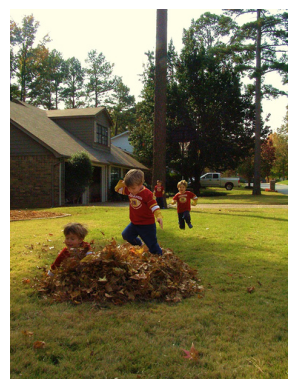

Actual Caption: A man hiking in the wilderness giving the camera a thumbs up .
Predicted Caption <SOS> a man in a red shirt is standing in front of a mountain with a mountain in the background . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.4284572


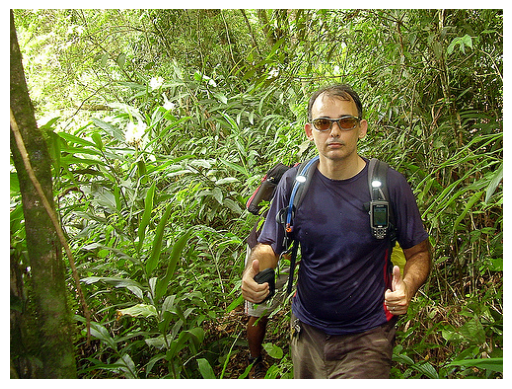

Actual Caption: A white dog is running through the water onto the shore .
Predicted Caption <SOS> a white dog is running through the water . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.8860149


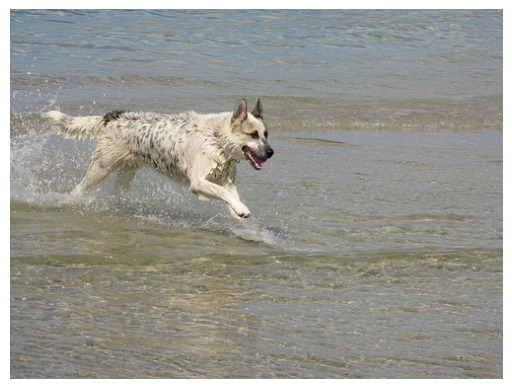

Actual Caption: a young man relaxing his legs on a pice of machinery
Predicted Caption <SOS> a man and a woman are sitting on a bench in front of a building . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.35097378


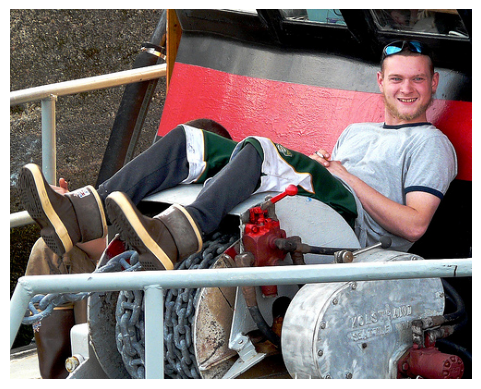

Actual Caption: a man in a yellow cap is on the beach carrying a fishing pole .
Predicted Caption <SOS> a young boy is standing on a beach with his arms outstretched . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.44065142


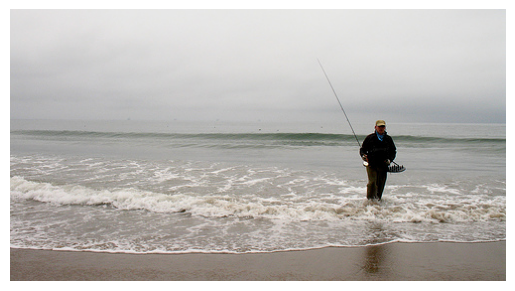

Actual Caption: A collie is running through an obstacle course
Predicted Caption <SOS> a dog jumps over a hurdle . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.57308817


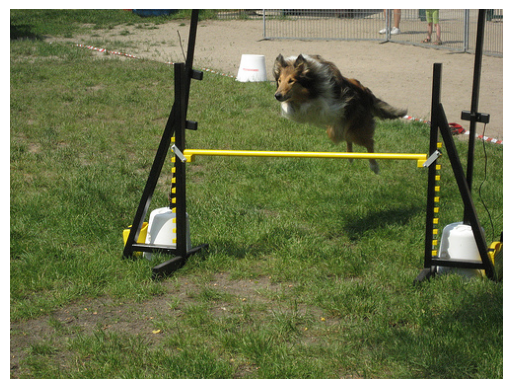

Actual Caption: Three kids stand in an array of water fountains .
Predicted Caption <SOS> a boy in a blue shirt is jumping into a pool . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.23252207


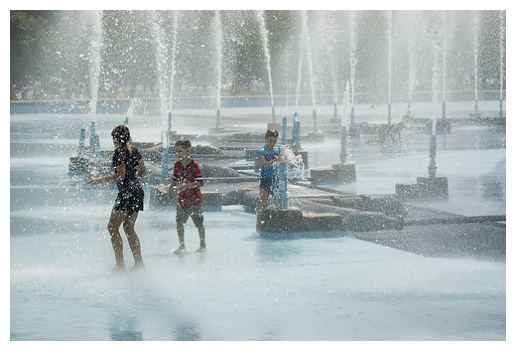

Actual Caption: A dog in mid-flight catches an orange and blue ball in a field of dead grass .
Predicted Caption <SOS> a black and white dog is running through the grass . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.6058022


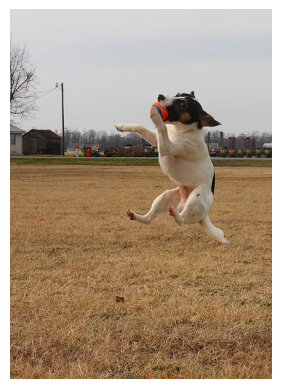

Actual Caption: A snowboarder performs a trick on a ledge , with pristine snowscapes surrounding him .
Predicted Caption <SOS> a snowboarder is jumping over a railing in the snow . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.6237187


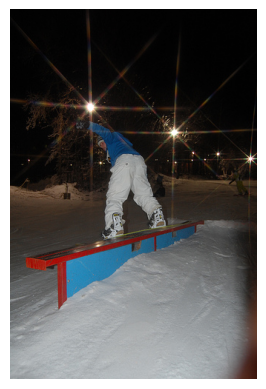

Actual Caption: Two dogs wrestle in the grass .
Predicted Caption <SOS> a black dog is running through the grass . <EOS>
Sentiment Score: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Similarity between actual output and predicted: 0.5975057


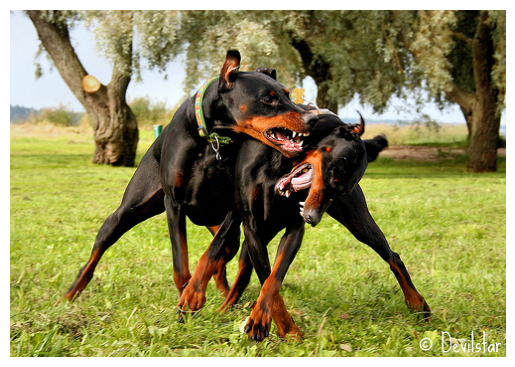



	Average similarity between Predicted and real caption = 0.5044023394584656




In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon (if not already downloaded)
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Load Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


def generate_caption_for_image(model, device, image_path, transform):
    try:
        img = Image.open(image_path).convert("RGB")
        test_img = transform(img).unsqueeze(0).to(device)

        # Get predicted caption
        predicted_caption = " ".join(model.caption_image(test_img, dataset.vocab))
        sentiment_score = sid.polarity_scores(predicted_caption)
        return img, predicted_caption, sentiment_score

    except Exception as e:
        print(f"Error processing image '{image_path}': {str(e)}")
        return None, None


def evaluate_model(model, device, image_paths,caption):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    model.eval()

    similarities = []
    for idx, image_path in enumerate(image_paths):
        img, predicted_caption, sentiment_score = generate_caption_for_image(model, device, image_path, transform)

        # Check if img is None (error occurred)
        if img is None:
            continue

        # Display image
        plt.imshow(img)
        plt.axis('off')

        embedding1 = embed([caption[idx]])[0].numpy()
        embedding2 = embed([predicted_caption])[0].numpy()

        similarity = cosine_similarity([embedding1], [embedding2])[0][0]
        similarities.append(similarity)

        # Display predicted caption
        print("Actual Caption:",caption[idx])
        print("Predicted Caption",predicted_caption)
        print("Sentiment Score:", sentiment_score)
        print("Similarity between actual output and predicted:", similarity)
        plt.show()

    model.train()
    print(f"\n\n\tAverage similarity between Predicted and real caption = {np.mean(similarities)}\n\n")




captionsofdata = pd.read_csv(annotation_file)

image_path = []
caption = []
for index, row in captionsofdata.sample(n=10, random_state=1).iterrows():
    image_path.append(f"flickr/Images/{row['image']}")
    caption.append(row['caption'])


logits_flag = False

evaluate_model(model, device, image_path, caption)